# Lab 3 Dimensionality reduction and clustering

The goal of this lab is to create a system that can automatically group pictures of a restaurant's dishes. This will require three steps: first we have to read and process the images in a way that they can be processed by machine learning algorithms. As these images are quite large, we'll need to reduce the dimensionality to keep it from requiring too much compute and memory. And finally we need to try out clustering algorithms to actually group the data.

We have already prepared a  dataset of images for you to try this out on. All of them were resized to 128 x 128 pixels, and contain color information meaning for each pixel they have a value for Red Green and Blue.

## Preparing images for machine learning

Machine learning models typically expect a one dimensional feature vector as input. Each image contains 128 X 128 x 3 or nearly 49,152 pixels. We could proceed by simply using each pixel value as a feature. This might work for relatively small images but will not scale to higher resolutions. Even worse is the fact that we lose a lot of spatial information by reducing the 2D image to a flat 1D vector. Individual pixels are not completely independent: there is a lot of information contained in the relation between two neighboring pixels, but flattening would remove this information.

We will therefore manually craft other features. This step is called **feature extraction** on the input images. This reduces the dimensionality to something more suitable for a machine learning model. There are a lot of feature extraction algorithms for images such as **SIFT, SURF** and **HOG**. Typically, they look for edges or color transitions that might be useful for the machine learning task. We will use the **histogram of oriented gradients** (HOG) algorithm to extract features.

The core idea behind HOG features is to describe the image as a set of edge directions within a part of the image. The image is divided into small connected regions called cells, and for the pixels within each cell, a histogram of gradient directions is compiled. These measure how much the pixel intensities change in each direction. For improved accuracy, the local histograms can be contrast-normalized by calculating a measure of the intensity across a larger region of the image, called a block. HOG typically works with grayscale values, however we can easily adapt to rgb images by taking combining the hog features of each color map.

In [5]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image

df = pd.read_csv("tripadvisor_dataset/image_labels.csv")

# this block of code reads in all images and stores them as 128x128x3 numpy arrays
images = np.zeros((len(df), 128* 128* 3))
for i, row in tqdm(df.iterrows(), total=len(df)):

    # read in image with pil 
    img = Image.open(f"tripadvisor_dataset/data/images/{row['file']}")
    img_np = np.array(img).flatten()
    images[i] = img_np / 255
    print(img_np / 255)
    break


  0%|          | 0/119 [00:00<?, ?it/s]

[0.02352941 0.01960784 0.03921569 ... 0.86666667 0.8627451  0.88627451]


To give you an idea of what HOG features are trying to capture, you can execute the following code block to see a visualisation of them on the first image

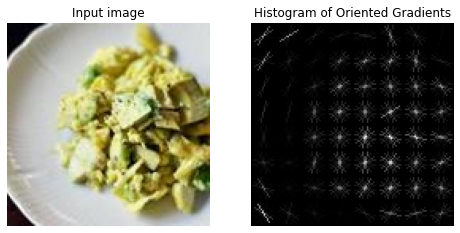

In [2]:
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

# plt.imshow(images[0].reshape((128,128,3)))
img = images[0].reshape(128,128,3)

fd, hog_image = hog(img,orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

Finally, we should capture and combine these features of all our images

In [3]:
images_hogs = np.zeros((images.shape[0], 512 * 3))

for i, img in tqdm(enumerate(images), total=len(images)):

    img = img.reshape((128,128,3))
    for channel in range(3):
        fd = hog(img[:,:,channel] ,orientations=8, pixels_per_cell=(16, 16),
                cells_per_block=(1, 1), visualize=False, feature_vector=True)
        images_hogs[i, channel*512:channel*512+512] = fd

100%|██████████| 119/119 [00:02<00:00, 53.74it/s]


## Clustering

Now on to clustering. Just for reference start out by trying out KMeans clustering on the raw pixel values to see how long it would take, then try it out on the HOG features. Remember that you should always standardize your data before applying KMeans!

In [4]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import time

# elk element in images_hogs is een image


# # scale hog and pixel features
sc = StandardScaler()
hogs_scaled = sc.fit_transform(images_hogs)

raw_scaled = sc.fit_transform(images)

# Run KMeans on pixel values
start = time.time()


kmeans2 = KMeans(n_clusters=5, random_state=0)
kmeans2.fit_predict(raw_scaled)

pixel_time = time.time()
print(f"Time to run KMeans on Pixel values: {pixel_time - start} seconds")

# Run KMeans on HOG values
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit_predict(hogs_scaled)


print(f"Time to run KMeans on HOG values: {time.time()- pixel_time} seconds")

Time to run KMeans on Pixel values: 1.959195852279663 seconds
Time to run KMeans on HOG values: 0.1800549030303955 seconds


This difference might not seem that significant because it will still run in seconds. However, keep in mind that we're working with a very tiny dataset. In practice it is not unimaginable to work with tens of thousands of images and then the difference will only become more significant.

To reduce the dimensionality even further we can use a technique such as PCA

### Principal Component Analysis

To perform PCA you must perform a couple of steps, we've repeated them here from the theory slides:

1. Center-mean the dataset.
2. Compute the covariance matrix of the whole dataset.
3. Compute eigenvectors and the corresponding eigenvalues of the covariance matrix.
4. Sort the eigenvectors by decreasing eigenvalues
5. Form an 𝑛 × 𝑑 matrix W containing the eigenvectors corresponding with the 𝑑 largest eigenvalues
6. Use this 𝑑 × 𝑘 eigenvector matrix to transform the samples onto the new subspace.
7. (If needed: calculate a reconstruction of the projected data by multiplying with the inverse of W

You can do all these steps manually using various numpy functions, as can be seen in the code below

In [5]:
# 1. Center-mean the dataset -> already done

# 2. Compute the covariance matrix (hint you can easily do this with np.cov)
cov_matrix = np.cov(hogs_scaled, rowvar=False)
# 3. Compute the eigenvectors and eigenvalues of the covariance matrix, again made easy by using np.linalg.eig
evals, evecs = np.linalg.eig(cov_matrix)
# 4. Sort the eigenvectors by decreasing eigenvalues
indices = np.argsort(evals)
# 5. take out the 50 largest values
indices = indices[-50:]
good_evecs = evecs[:, indices]
good_evals = evals[indices]
# 6. use this matrix to transform the samples to the new subspace
result = np.dot(hogs_scaled, good_evecs)

In [6]:
result.shape

(119, 50)

### PCA in scikit-learn

Of course PCA also exists in the scikit-learn library, so we can just as easily replace the last code block with a PCA model

<font color='red'>Task: reduce the dimensionality of the hog features to 50 by using scikit-learns PCA.</font>

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
new_hogs = pca.fit_transform(hogs_scaled)
new_hogs.shape

(119, 50)

In the previous exercise, we manually specified $k=50$ as the number of dimensions to reduce the dataset to. This choice was rather arbitraty. It could be that this is too restrictive, or possibly we can reduce the amount of features even more. The lower $k$, the more we compress our dataset, but the more information about the variance we throw away. So, how to determine the optimal number of $k$?

Remember that the principal components were the eigenvectors $v_i$ (with unit length) of the covariance matrix C, with eigenvalues sorted in decreasing order ($\lambda_i > \lambda_{i+1}$).

$$
C = \sum_{i=1}^d \lambda_i v_i v_i^T
$$

Since (by convention) our eigenvectors have unit length, the ratio of the variance explained by the first $k$ principal components is:
$$
\frac{\lambda_1 + \lambda_2 + \dotsb + \lambda_k}{\lambda_1 + \lambda_2 + \dotsb + \lambda_k + \dotsb + \lambda_d}
$$


By plotting this ratio of explained variance as a function of $k$, we can apply the same elbow method as we used to determine the number of clusters in k-means clustering.

<font color='red'>Task: Create a new PCA object without specifying the number of components to use. The ratio above is available as an attribute of the pca object. You get the correct values by calculating a cumulative sum (np.cumsum) on this pca attribute. Try it out on both the HOG features as the pixel values</font>

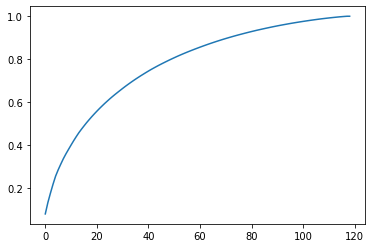

In [8]:
# PCA on pixel value

pca = PCA()
pca.fit(hogs_scaled)
a = np.cumsum(pca.explained_variance_ratio_)
plt.plot(a)

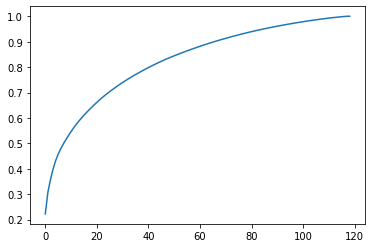

In [9]:
# PCA on hog features
pca = PCA()
pca.fit(raw_scaled)
a = np.cumsum(pca.explained_variance_ratio_)
plt.plot(a)

<font color='red'>Task: With this insight, how much components would you use on our food images?.</font>

## Clustering on PCA features

Now that we have these features we can move back to clustering, try out KMeans clustering again on the reduced data

In [24]:
pca_final = PCA(n_components=90)
hogs_final = pca.fit_transform(hogs_scaled)

kmeans_final = KMeans(n_clusters=5)
predictions = kmeans_final.fit_predict(hogs_final)

images.shape

(119, 49152)

Of course, we should also evaluate our clustering. With images, a good first step is to just take a look at what images are clustered together. Use the following function to look at what images are clustered together. Also take a look at the clusterings we got with the raw pixel values and the unreduced hog features. Which one looks best? 

CLUSTER 0


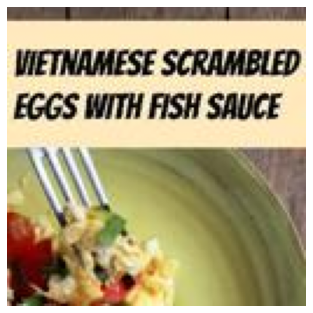

CLUSTER 1


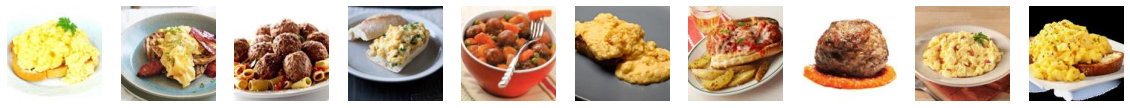

CLUSTER 2


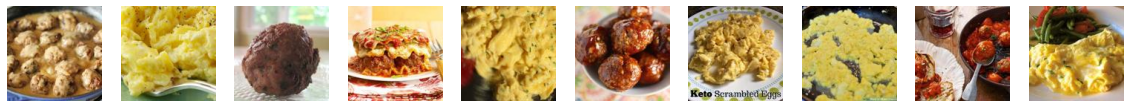

CLUSTER 3


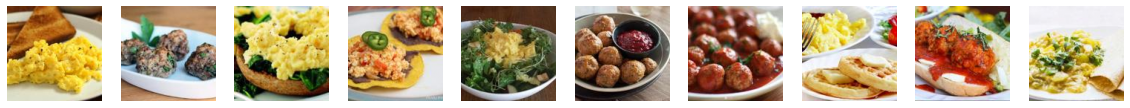

CLUSTER 4


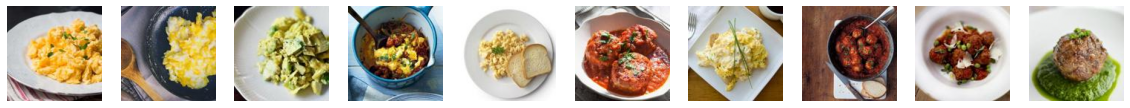

In [25]:
# you can optionally give this function the distances of the instances to the cluster centers (obtainable by using the models transform function)
def show_predictions(predictions, n_clusters, images, distances=None):
    for cluster in range(n_clusters):
        print(f"CLUSTER {cluster}")

        cluster_images = images[np.where(predictions == cluster)]

        if distances is not None:
            # we sort the images so that they are displayed in order of distance to cluster center
            cluster_distances=  np.min(distances[np.where(predictions == cluster)], axis=1)
            cluster_instances_sorted = np.argsort(cluster_distances)
            cluster_images = cluster_images[cluster_instances_sorted[::-1]]
                
        num_pics = 10 if cluster_images.shape[0] > 10 else cluster_images.shape[0]

        # try to pick out images closes to the cluster centers
        if num_pics == 0:
            print("No images in this cluster")
            continue
        if num_pics == 1:
            plt.figure()
            plt.imshow(cluster_images[0].reshape((128,128,3)))
            plt.axis("off")
            plt.show()
            continue
        indices = np.random.choice(np.arange(cluster_images.shape[0]), num_pics, replace=False)
        _, axs = plt.subplots(1, num_pics, figsize=(20,20))
        axs = axs.flatten()
        for img, ax in zip(cluster_images[indices], axs):
            ax.imshow(img.reshape((128,128,3)))
            ax.set_axis_off()
        plt.show()

show_predictions(predictions, 5, images)

So the clusterings probably don't look pretty good. However, we just picked the default value for the amount of clusters. By just looking at the images you probably already figured out how many clusters there should be, but try to use the elbow method to find out aswell.

<font color=red>
Task: create an elbow plot for values of $k$ between 2 and 10. We can use the <a href="https://www.scikit-yb.org/en/latest/index.html"> yellowbrick</a> package for this, a handy machine learning visualisation library (you might have to install this package using pip install yellowbrick or conda install yellowbrick). Use the <a href="https://www.scikit-yb.org/en/latest/api/cluster/elbow.html#elbow-method">KElbowVisualiser</a> to implement the elbow method.  Is the value of the elbow corresponding to the value you would "manually" derive from a visual inspection of the plot you made above?
</font>

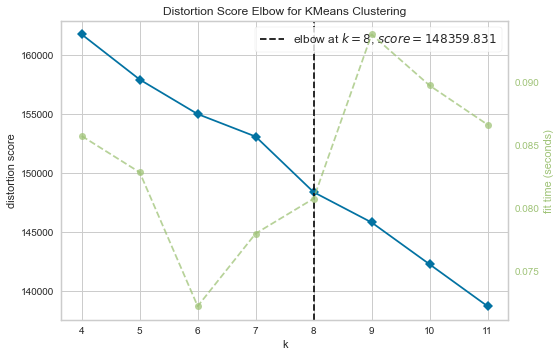

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [26]:
from yellowbrick.cluster import KElbowVisualizer


model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))
visualizer.fit(hogs_final)
visualizer.show()


You likely got some bad results on the elbow plot. It seems the KMeans model is just unable to find any decent clusterings in this range. It might be that the features we use are just not properly fit for this task. We should try to look at the silhouette plots, and see if these give similar results.

<font color=red>
Task: Create silhouette plots for $k=4$ and $k=2$ to see the difference between *good* and *bad* clustering. With suboptimal clustering, the silhouettes have visibly different lengths and widths.  
Again, use the yellowbrick package for this, documentation can be found <a href="https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html#quick-method">here</a>
</font>

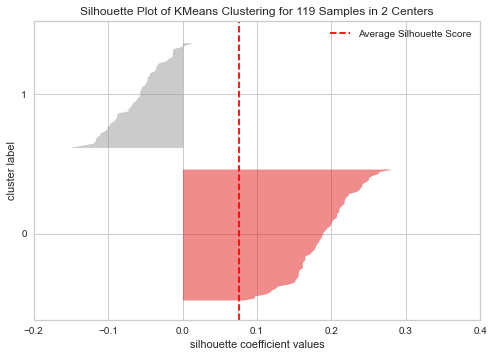

SilhouetteVisualizer(ax=<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 119 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     estimator=KMeans(n_clusters=2))

In [27]:
from yellowbrick.cluster import silhouette_visualizer
from yellowbrick.cluster import SilhouetteVisualizer

silhouette_visualizer(KMeans(2), hogs_final)

These also probably don't look amazing. The issues could be at a couple of places:

- The data we use is too noisy to perform clustering
- The image features we extract are not representative enough, or remove too much of the vital information for clustering
- The dimensionality reduction technique was not the right fit (we used a linear technique, maybe non-linear would be a better fit?)
- The KMeans algorithm is not the best clustering algorithm for our type of data

Let's try to improve our results by investigating two of these: using a non-linear dimensionality reduction technique and a different clustering algorithm.

### Kernel PCA

For our non-linear dimensionality reduction we'll try out Kernel PCA. Take a look at scikit-learn's kernel pca and try it out on our data.

<font color=red>
Task: use KernelPCA to get new features, try out different kernels and find out which one is best.</a>
</font>

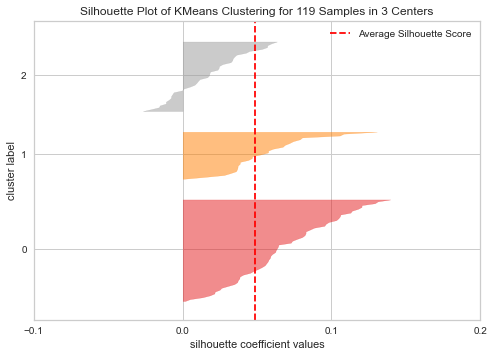

SilhouetteVisualizer(ax=<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 119 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     estimator=KMeans(n_clusters=3))

In [28]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=90, kernel='cosine')
transformed = kpca.fit_transform(hogs_scaled)
transformed.shape

silhouette_visualizer(KMeans(3), transformed)

# Hierarchical clustering

For our last clustering algorithm we're going to take a look at hierarchical clustering. Hierarchical clustering algorithms can be divided in two categories:
- **Agglomerative or bottom up**: we treat all points as individual clusters and merge (or agglomorate) clusters until there is only one cluster left with all points
- **Divisive or top down**: We start out with one cluster that contains all the points and succesively split this cluster as we move down the hierarchy


This lab we are going to focus on agglomerative hierarchical clustering. To visualise this clustering we use tree diagrams or **dendrograms** (*déndron* = tree, *grámma*=drawing). An example of how agglomorative hierarchical clustering and the corresponding dendrogram works can be found in the GIF below. 

<div>
    <img src="images/agglomerative_hierarchical_clustering.gif" width="800" />
    <br/>Source: <a href="https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68">The 5 Clustering Algorithms Data Scientists Need to Know</a>

</div>

Our algorithm needs two distance functions. One to find the distance between two points, we call this the  **affinity**, and another to measure distance between clusters, this is called the **linkage** function.

Using these functions we can define the algorithm with the following steps:
1. Start by treating each data point as a single cluster.
2. Combine the two clusters that have the smallest linkage
3. Repeat step 2 until either we have the amount of clusters we want or the distance between the remaining clusters becomes too large

As always sklearn is there to help us with a tried and tested implementation of the [agglomorative clustering algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html).

<font color="red"> Task: Use the agglomerative clustering algorithm on the food image data and analyze the results. </font>

CLUSTER 0


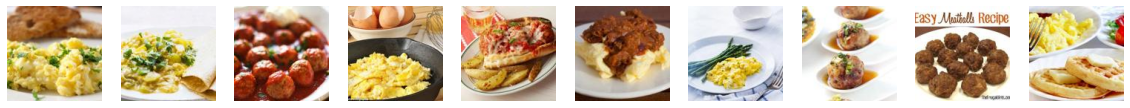

CLUSTER 1


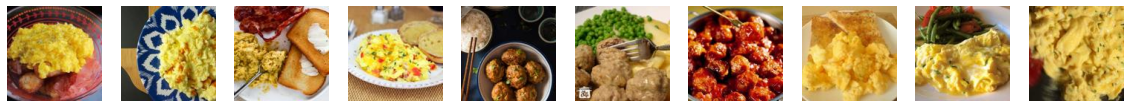

CLUSTER 2


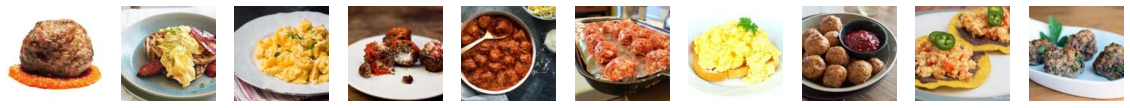

CLUSTER 3


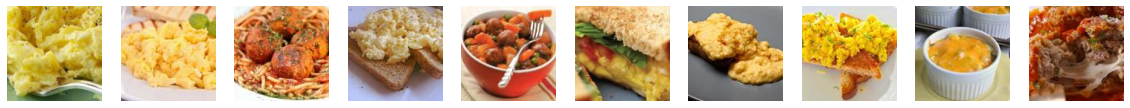

In [29]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=4)
agg_res = agg.fit_predict(transformed)
show_predictions(agg_res, 4, images)

There are also some metrics we can use for evaluating clusterings, for example:

- **Silhouette score**: Measures separation distance between clusters. Value between -1 (worst score) and +1 (best score)
- **Davies-Bouldin Index**: Average similarity measure of each cluster with its most similar cluster. Minimum score is 0 with lower values indicating better clustering

<font color="red">Task: compare the results of the clustering using the silhouette score and the Davies-Bouldin Index</font>

In [30]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score


print(silhouette_score(hogs_scaled, agg_res))
print(davies_bouldin_score(hogs_scaled, agg_res))


0.024141022708487888
3.9109220670324465


Are you happy with the final results? You could always try out some of the other suggestions made above. It's not improbable that our features are not representative enough. Perhaps you could try out some of the other techniques such as SIFT, SURF, BRIEF. You can find a series of blog posts on feature extraction here: https://medium.com/@deepanshut041/introduction-to-feature-detection-and-matching-65e27179885d. Later on, we will see that deep learning can also help us with extracting feature.


You can try to improve upon our results in the project, the full dataset we used can be found here https://github.com/karansikka1/iFood_2019. It contains a lot more images of food than we used, perhaps you can try to cluster bigger overlaying groups like desserts or pastas?